In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'emotion-recognition-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4804432%2F8128836%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240416%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240416T045909Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6d7cd45bf5b0bdcda49730a5626523cad9201b3c60630801f0d9c984750ca406d0684e078433a2f64f346057df23a1bc2b06d5ba45e9abb13bf9698a3a822f37d5196ddf8d4afe860691907520f2ab1b12044c2916946c6903ce515321758f4b231ea12ceba624a24dca38da301450c93114a6cbdd63e190756dacc197936d16ff0e4bf5cc1e25a7a68baf92233d8f0ec4a430771857ccf654297235ca70c093a215343223d64b83909d319fb5987d8c1a56923be83816f177bb5a31cd556c02f75f04ec0c2165a9b5b593afcb69ef0740ddcd091efd3ffbce126445b98823bb675309898ee20b62848d3df59ad8e733da43f4660c4b853cf11bee45e965acc1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 180508264 bytes downloaded
Downloaded and uncompressed: emotion-recognition-data
Data source import complete.


In [2]:
!python -V

Python 3.10.12


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore")
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50V2, DenseNet121
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
%pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tf_keras


In [5]:
%pip show keras

Name: keras
Version: 2.15.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: tensorflow


In [6]:
%pip show scikit-learn

Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, qudida, sklearn-pandas, yellowbrick


In [7]:
%pip show matplotlib

Name: matplotlib
Version: 3.7.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /usr/local/lib/python3.10/dist-packages
Requires: contourpy, cycler, fonttools, kiwisolver, numpy, packaging, pillow, pyparsing, python-dateutil
Required-by: arviz, bigframes, datascience, fastai, geemap, imgaug, matplotlib-venn, missingno, mizani, mlxtend, music21, plotnine, prophet, pycocotools, seaborn, wordcloud, yellowbrick


In [8]:
def create_dataframe(data_dir):
    image_paths = []
    labels = []

    # Step 1: Read all folders from the directory
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)

        # Step 2: Read images in each folder
        for filename in os.listdir(label_dir):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(label_dir, filename))
                labels.append(label)

    # Step 3: Create a pandas DataFrame
    df = pd.DataFrame({'image_path': image_paths, 'label': labels})

    return df

In [9]:
data_dir = '/kaggle/input/emotion-recognition-data/Dataset'
df = create_dataframe(data_dir)
df.head(10)

,image_path,label
0,/kaggle/input/emotion-recognition-data/Dataset...,Confusion
1,/kaggle/input/emotion-recognition-data/Dataset...,Confusion
2,/kaggle/input/emotion-recognition-data/Dataset...,Confusion
3,/kaggle/input/emotion-recognition-data/Dataset...,Confusion
4,/kaggle/input/emotion-recognition-data/Dataset...,Confusion
5,/kaggle/input/emotion-recognition-data/Dataset...,Confusion
6,/kaggle/input/emotion-recognition-data/Dataset...,Confusion
7,/kaggle/input/emotion-recognition-data/Dataset...,Confusion
8,/kaggle/input/emotion-recognition-data/Dataset...,Confusion
9,/kaggle/input/emotion-recognition-data/Dataset...,Confusion


In [10]:
df.label.value_counts()

label
Confidence     5837
Confusion      5305
Nervousness    5093
Name: count, dtype: int64

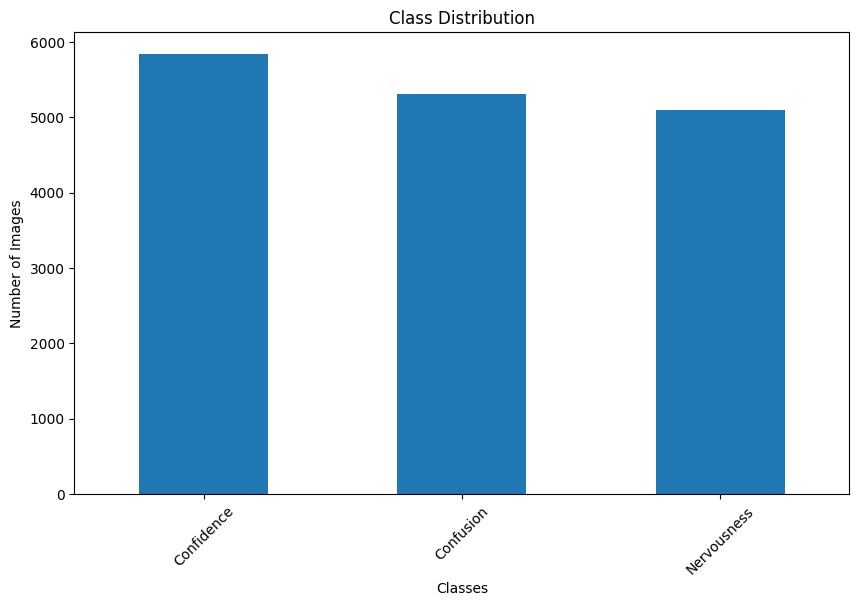

In [11]:
class_distribution = df['label'].value_counts()
class_distribution.plot(kind='bar', figsize=(10, 6))
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [12]:
def balance_dataset(df):
    # Calculate the number of samples in each class
    class_counts = df['label'].value_counts()

    # Find the class with the minimum number of samples
    min_class_count = class_counts.min()

    # Create an empty list to store balanced dataframes
    balanced_dfs = []

    # Loop through each class
    for label, count in class_counts.items():
        # If the class count is greater than the minimum, perform random undersampling
        if count > min_class_count:
            class_df = df[df['label'] == label]
            balanced_df = resample(class_df, replace=False, n_samples=min_class_count, random_state=42)
        # If the class count is less than the minimum, perform random oversampling
        elif count < min_class_count:
            class_df = df[df['label'] == label]
            balanced_df = resample(class_df, replace=True, n_samples=min_class_count, random_state=42)
        # If the class count is equal to the minimum, keep the dataframe as is
        else:
            balanced_df = df[df['label'] == label]

        # Add the balanced dataframe to the list
        balanced_dfs.append(balanced_df)

    # Concatenate the balanced dataframes
    return pd.concat(balanced_dfs)

In [13]:
df = balance_dataset(df)
print(df['label'].value_counts())

label
Confidence     5093
Confusion      5093
Nervousness    5093
Name: count, dtype: int64


In [14]:
len(df)

15279

In [15]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, val_df = train_test_split(test_df, test_size=0.65, random_state=42)

print("Train set size:", len(train_df),"\nTest set size:", len(test_df),"\nValidation set size:", len(val_df))

Train set size: 12223 
Test set size: 1069 
Validation set size: 1987


In [16]:
def img_generation(train_datagen,test_datagen):
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='data_dir',  # Path to the directory containing images
        x_col='image_path',  # Column containing image paths
        y_col='label',  # Column containing labels
        target_size=(96, 96),  # Target size for resizing images
        batch_size=64,  # Batch size
        class_mode='categorical'  # Use categorical labels
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='data_dir',  # Path to the directory containing images
        x_col='image_path',  # Column containing image paths
        y_col='label',  # Column containing labels
        target_size=(96, 96),  # Target size for resizing images
        batch_size=64,  # Batch size
        class_mode='categorical'  # Use categorical labels
    )

    val_generator = test_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='data_dir',  # Path to the directory containing images
        x_col='image_path',  # Column containing image paths
        y_col='label',  # Column containing labels
        target_size=(96, 96),  # Target size for resizing images
        batch_size=64,  # Batch size
        class_mode='categorical'  # Use categorical labels
    )

    return (train_generator,test_generator,val_generator)

In [45]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=15,  # Random rotation by up to 15 degrees
    width_shift_range=0.1,  # Randomly shift width by up to 10%
    height_shift_range=0.1,  # Randomly shift height by up to 10%
    shear_range=0.1,  # Shear intensity (max 10%)
    zoom_range=0.1,  # Random zoom by up to 10%
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # No vertical flipping
    fill_mode='nearest',  # Fill mode for pixel values outside boundaries
    preprocessing_function = tensorflow.keras.applications.vgg16.preprocess_input
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function = tensorflow.keras.applications.vgg16.preprocess_input
)  # Only rescale pixel values for test set

# Flow images from directory using the data generators
train_generator, test_generator, val_generator = img_generation(train_datagen,test_datagen)

Found 12223 validated image filenames belonging to 3 classes.
Found 1069 validated image filenames belonging to 3 classes.
Found 1987 validated image filenames belonging to 3 classes.


In [48]:
classes = train_generator.class_indices
classes

{'Confidence': 0, 'Confusion': 1, 'Nervousness': 2}

In [18]:
# Load the VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom fully connected layers on top of the base model
model = Sequential([
    base_model,
    Flatten(name = 'classify_flatten'),
    Dense(256, activation='relu', name = 'classify_dense_1'),
    Dense(128, activation='relu', name = 'classify_dense_2'),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 classify_flatten (Flatten)  (None, 4608)              0         
                                                                 
 classify_dense_1 (Dense)    (None, 256)               1179904   
                                                                 
 classify_dense_2 (Dense)    (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 15927875 (60.76 MB)
Trainable params: 1213187 (4.63 MB)
Non-trainable params: 14714688 (56.13 MB)
___________

In [19]:
epochs = 100
batch_size = 64

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [21]:
# Train the model
vgg_history = model.fit(train_generator,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=val_generator,
          callbacks=[early_stopping]
         )

Epoch 1/100
191/191 [==============================] - 59s 275ms/step - loss: 0.8124 - accuracy: 0.6384 - val_loss: 0.7179 - val_accuracy: 0.6865
Epoch 2/100
191/191 [==============================] - 43s 225ms/step - loss: 0.6851 - accuracy: 0.7046 - val_loss: 0.6865 - val_accuracy: 0.7071
Epoch 3/100
191/191 [==============================] - 43s 223ms/step - loss: 0.6586 - accuracy: 0.7141 - val_loss: 0.6294 - val_accuracy: 0.7418
Epoch 4/100
191/191 [==============================] - 42s 219ms/step - loss: 0.6354 - accuracy: 0.7268 - val_loss: 0.6253 - val_accuracy: 0.7438
Epoch 5/100
191/191 [==============================] - 42s 220ms/step - loss: 0.6220 - accuracy: 0.7312 - val_loss: 0.6184 - val_accuracy: 0.7484
Epoch 6/100
191/191 [==============================] - 42s 221ms/step - loss: 0.6069 - accuracy: 0.7410 - val_loss: 0.6510 - val_accuracy: 0.7232
Epoch 7/100
191/191 [==============================] - 43s 226ms/step - loss: 0.5923 - accuracy: 0.7464 - val_loss: 0.6252 -

In [22]:
save_model(model, "vgg16.h5")

In [ ]:
def testing(model):
    test_loss, test_acc = model.evaluate(train_generator)
    print("Test Accuracy:", test_acc,"\nTest Loss:", test_loss)

In [49]:
print("VGG16")
testing(model)

VGG16
191/191 [==============================] - 41s 214ms/step - loss: 0.5324 - accuracy: 0.7745
Test Accuracy: 0.7745234370231628 
Test Loss: 0.5324475169181824


# Resnet50v2

In [42]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=15,  # Random rotation by up to 15 degrees
    width_shift_range=0.1,  # Randomly shift width by up to 10%
    height_shift_range=0.1,  # Randomly shift height by up to 10%
    shear_range=0.1,  # Shear intensity (max 10%)
    zoom_range=0.1,  # Random zoom by up to 10%
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # No vertical flipping
    fill_mode='nearest',  # Fill mode for pixel values outside boundaries
    preprocessing_function = tensorflow.keras.applications.resnet_v2.preprocess_input
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function = tensorflow.keras.applications.resnet_v2.preprocess_input
)

train_generator, test_generator, val_generator = img_generation(train_datagen,test_datagen)

Found 12223 validated image filenames belonging to 3 classes.
Found 1069 validated image filenames belonging to 3 classes.
Found 1987 validated image filenames belonging to 3 classes.


In [24]:
# Create ResNet50V2 base model
resnet_base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze base model layers
for layer in resnet_base_model.layers:
    layer.trainable = False

# Add custom head to the base model
resnet_model = Sequential([
    resnet_base_model,
    GlobalAveragePooling2D(name='resnet_global_average_pooling'),
    Dense(256, activation='relu', name='resnet_dense'),
    Dense(3, activation='softmax', name='resnet_output')
])

# Compile ResNet50V2 model
resnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

94668760/94668760 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 resnet_global_average_pool  (None, 2048)              0         
 ing (GlobalAveragePooling2                                      
 D)                                                              
                                                                 
 resnet_dense (Dense)        (None, 256)               524544    
                                                                 
 resnet_output (Dense)       (None, 3)                 771       
                                                                 
Total params: 24090115 (91.90 MB)
Trainable params: 525315 (2.00 MB)
Non-trainable params: 23564800 (89.89 MB)
__________

In [25]:
# Train ResNet50V2 model
resnet_history = resnet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/100
191/191 [==============================] - 50s 231ms/step - loss: 1.0255 - accuracy: 0.4698 - val_loss: 0.9319 - val_accuracy: 0.5576
Epoch 2/100
191/191 [==============================] - 42s 220ms/step - loss: 0.9757 - accuracy: 0.5140 - val_loss: 0.8921 - val_accuracy: 0.5773
Epoch 3/100
191/191 [==============================] - 41s 214ms/step - loss: 0.9614 - accuracy: 0.5279 - val_loss: 0.8481 - val_accuracy: 0.6266
Epoch 4/100
191/191 [==============================] - 41s 214ms/step - loss: 0.9511 - accuracy: 0.5356 - val_loss: 0.8773 - val_accuracy: 0.5903
Epoch 5/100
191/191 [==============================] - 42s 218ms/step - loss: 0.9424 - accuracy: 0.5427 - val_loss: 0.8609 - val_accuracy: 0.6230
Epoch 6/100
191/191 [==============================] - 42s 218ms/step - loss: 0.9255 - accuracy: 0.5554 - val_loss: 0.8296 - val_accuracy: 0.6306
Epoch 7/100
191/191 [==============================] - 41s 213ms/step - loss: 0.9243 - accuracy: 0.5600 - val_loss: 0.9113 -

In [26]:
save_model(model, "resnet.h5")

In [43]:
print("ResNet")
testing(resnet_model)

ResNet
191/191 [==============================] - 39s 205ms/step - loss: 0.9191 - accuracy: 0.5626
Test Accuracy: 0.5626278519630432 
Test Loss: 0.919137716293335


# Densenet

In [40]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=15,  # Random rotation by up to 15 degrees
    width_shift_range=0.1,  # Randomly shift width by up to 10%
    height_shift_range=0.1,  # Randomly shift height by up to 10%
    shear_range=0.1,  # Shear intensity (max 10%)
    zoom_range=0.1,  # Random zoom by up to 10%
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # No vertical flipping
    fill_mode='nearest',  # Fill mode for pixel values outside boundaries
    preprocessing_function = tensorflow.keras.applications.densenet.preprocess_input
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function = tensorflow.keras.applications.densenet.preprocess_input
)

train_generator, test_generator, val_generator = img_generation(train_datagen,test_datagen)

Found 12223 validated image filenames belonging to 3 classes.
Found 1069 validated image filenames belonging to 3 classes.
Found 1987 validated image filenames belonging to 3 classes.


In [28]:
# Create DenseNet201 base model
densenet_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze base model layers
for layer in densenet_base_model.layers:
    layer.trainable = False

# Add custom head to the base model
densenet_model = Sequential([
    densenet_base_model,
    GlobalAveragePooling2D(name='densenet_global_average_pooling'),
    Dense(256, activation='relu', name='densenet_dense'),
    Dense(3, activation='softmax', name='densenet_output')
])

# Compile DenseNet201 model
densenet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
densenet_model.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 3, 3, 1024)        7037504   
                                                                 
 densenet_global_average_po  (None, 1024)              0         
 oling (GlobalAveragePoolin                                      
 g2D)                                                            
                                                                 
 densenet_dense (Dense)      (None, 256)               262400    
                                                                 
 densenet_output (Dense)     (None, 3)                 771       
                                                                 
Total params: 7300675 (27.85 MB)
Trainable params: 263171 (1.00 MB)
Non-trainable params: 7037504 (26.85 MB)
____________

In [29]:
# Train DenseNet201 model
densenet_history = densenet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/100
191/191 [==============================] - 57s 251ms/step - loss: 1.0875 - accuracy: 0.3889 - val_loss: 1.0320 - val_accuracy: 0.4701
Epoch 2/100
191/191 [==============================] - 42s 218ms/step - loss: 1.0346 - accuracy: 0.4558 - val_loss: 1.0177 - val_accuracy: 0.4464
Epoch 3/100
191/191 [==============================] - 43s 228ms/step - loss: 0.9944 - accuracy: 0.5051 - val_loss: 1.0171 - val_accuracy: 0.4811
Epoch 4/100
191/191 [==============================] - 42s 219ms/step - loss: 0.9747 - accuracy: 0.5138 - val_loss: 1.0453 - val_accuracy: 0.4308
Epoch 5/100
191/191 [==============================] - 42s 222ms/step - loss: 0.9695 - accuracy: 0.5111 - val_loss: 0.9746 - val_accuracy: 0.5133
Epoch 6/100
191/191 [==============================] - 42s 220ms/step - loss: 0.9619 - accuracy: 0.5208 - val_loss: 0.8955 - val_accuracy: 0.5908
Epoch 7/100
191/191 [==============================] - 42s 219ms/step - loss: 0.9345 - accuracy: 0.5463 - val_loss: 0.9068 -

In [30]:
save_model(densenet_model, "densenet.h5")

In [41]:
print("DenseNet")
testing(densenet_model)

DenseNet
191/191 [==============================] - 41s 214ms/step - loss: 0.9499 - accuracy: 0.5337
Test Accuracy: 0.5337478518486023 
Test Loss: 0.9498665928840637


# CNN

In [54]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=15,  # Random rotation by up to 15 degrees
    width_shift_range=0.1,  # Randomly shift width by up to 10%
    height_shift_range=0.1,  # Randomly shift height by up to 10%
    shear_range=0.1,  # Shear intensity (max 10%)
    zoom_range=0.1,  # Random zoom by up to 10%
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # No vertical flipping
    fill_mode='nearest',  # Fill mode for pixel values outside boundaries
  )

train_generator, test_generator, val_generator = img_generation(train_datagen,test_datagen)

Found 12223 validated image filenames belonging to 3 classes.
Found 1069 validated image filenames belonging to 3 classes.
Found 1987 validated image filenames belonging to 3 classes.


In [55]:
train_generator.class_indices

{'Confidence': 0, 'Confusion': 1, 'Nervousness': 2}

In [32]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Display the model summary
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 10, 10, 128)      

In [33]:
# Train DenseNet201 model
cnn_history = cnn_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/100
191/191 [==============================] - 42s 197ms/step - loss: 0.9422 - accuracy: 0.5288 - val_loss: 1.1944 - val_accuracy: 0.3387
Epoch 2/100
191/191 [==============================] - 38s 197ms/step - loss: 0.7397 - accuracy: 0.6776 - val_loss: 1.5160 - val_accuracy: 0.3387
Epoch 3/100
191/191 [==============================] - 37s 195ms/step - loss: 0.6642 - accuracy: 0.7210 - val_loss: 1.5319 - val_accuracy: 0.3387
Epoch 4/100
191/191 [==============================] - 38s 197ms/step - loss: 0.6097 - accuracy: 0.7547 - val_loss: 1.2699 - val_accuracy: 0.3387


In [34]:
save_model(cnn_model, "cnn.h5")

In [39]:
print("Testing CNN")
testing(model)

Testing CNN
191/191 [==============================] - 40s 207ms/step - loss: 0.6964 - accuracy: 0.7038
Test Accuracy: 0.7038370370864868 
Test Loss: 0.6964137554168701


# Inference

In [36]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name + ' Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model_name + ' Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

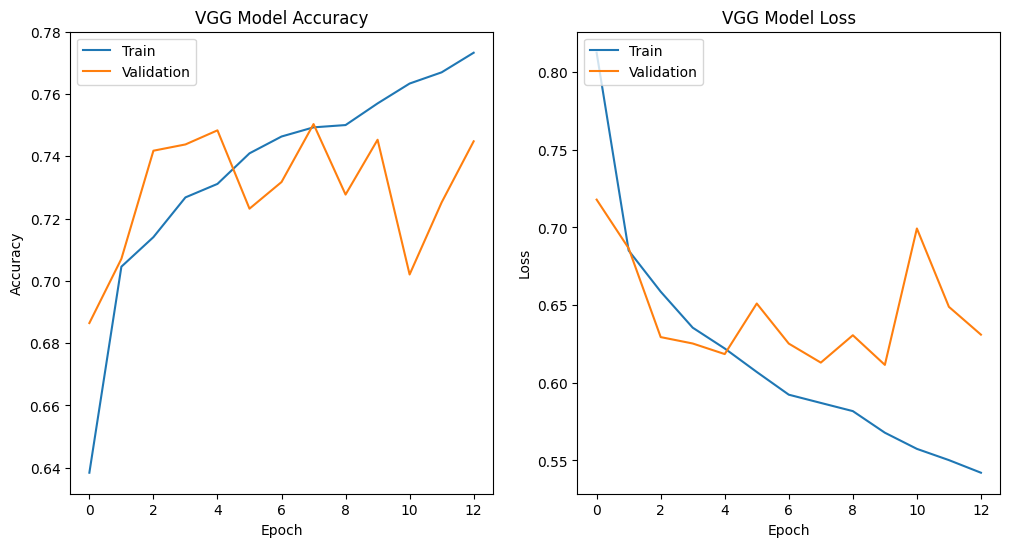

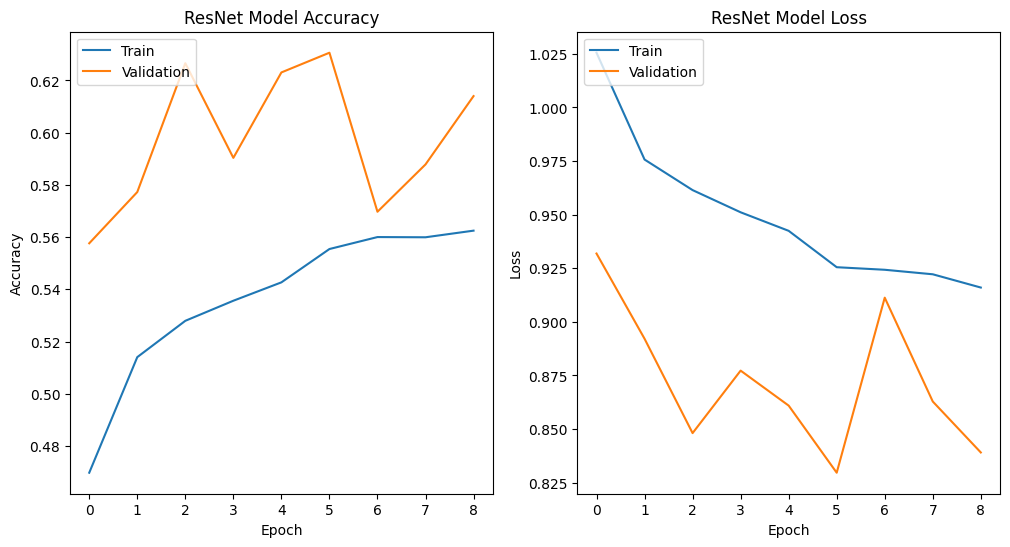

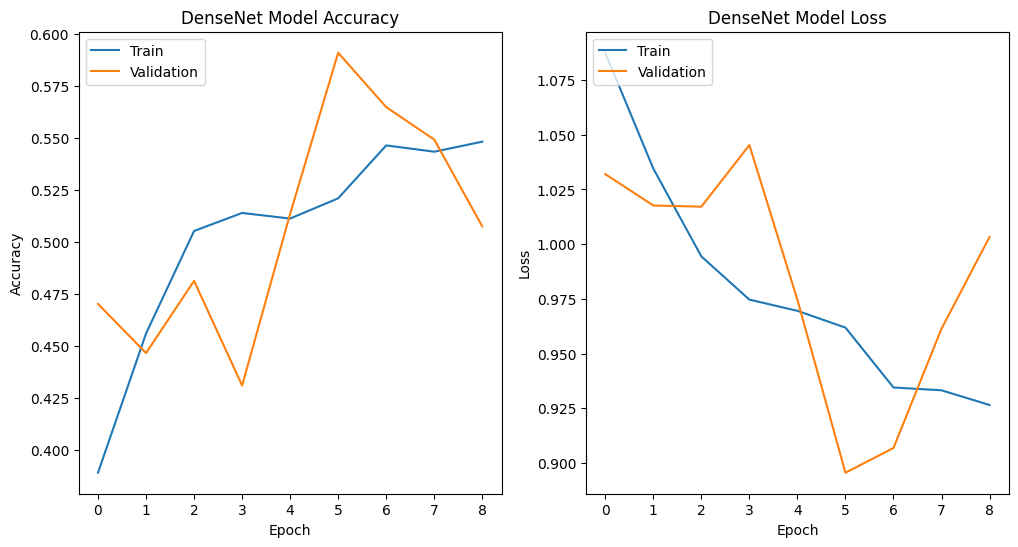

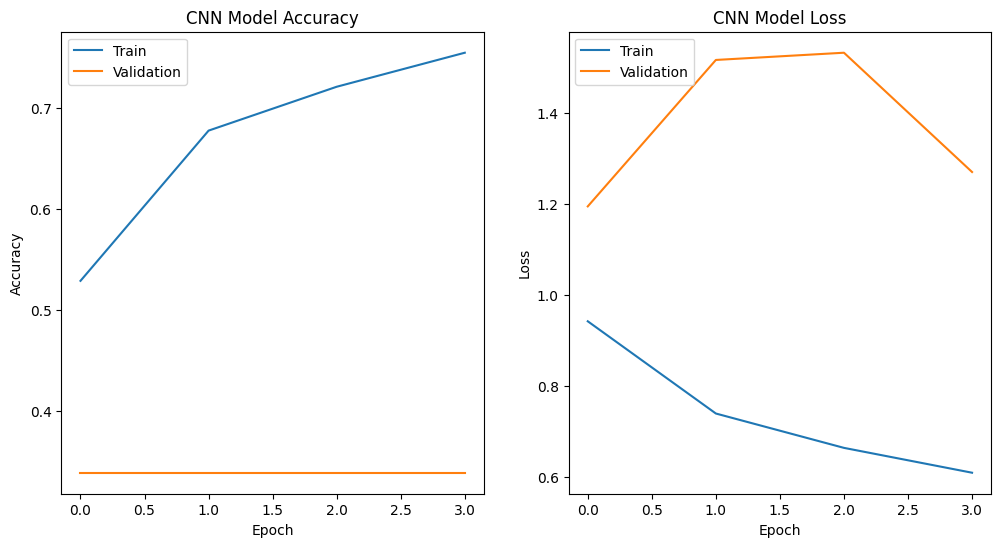

In [38]:
# Plotting history for each model
plot_history(vgg_history, 'VGG')
plot_history(resnet_history, 'ResNet')
plot_history(densenet_history, 'DenseNet')
plot_history(cnn_history, 'CNN')

In [56]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# Function to load and preprocess images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(96, 96))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [60]:
def pred():
  y_pred = []
  dire = os.path.join(data_dir,'Confidence')
  allfiles = os.listdir(dire)
  for f in allfiles:
    img = preprocess_image(os.path.join(dire,f))
    y = model.predict(img)
    y_pred.append(np.argmax(y))
  return y_pred

In [ ]:
y_pred = pred()